In [6]:
#import relevant libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import matplotlib.backends.backend_pdf
import random


In [7]:
# given: eval function
def eval(predicted_heatmaps, xy_sample_target):
    #predicted_heatmaps expects a Tensor of size num_shapesx25x17x17
    #xy_sample_target expects a Tensor of size num_shapesx25x289x2
    heatmap_width = predicted_heatmaps.size(3)
    predicted_xy = torch.zeros(25,2)
    #project heatmap to grid for each landmark
    for j in range(25):
        #perform the grid_sampling step in backwards direction
        gridded_heatmap = torch.zeros(1,1,320,312)
        gridded_heatmap.requires_grad = True
        values = predicted_heatmaps[:,j,:,:].view(1,1,-1,heatmap_width**2)
        out = F.grid_sample(gridded_heatmap,xy_sample_target[:,j:j+1,:,:].view(1,-1,heatmap_width**2,2))
        loss = (out*values).sum()
        loss.backward()
        #smooth the output to fill gaps
        avg5 = nn.AvgPool2d(7,stride=1,padding=3)
        gridded_heatmap = gridded_heatmap.grad
        gridded_heatmap = avg5(avg5(avg5(gridded_heatmap)))
        #read out maximum points with np.unravel
        y,x = np.unravel_index(int(torch.argmax(gridded_heatmap[0,0,:,:].view(-1))), (320,312))
        predicted_xy[j,:] = torch.Tensor([x,y]) 

    return predicted_xy


# new eval function
def own_eval(predicted_heatmaps, target_grids):

    predicted_pts = torch.zeros(9,25,2)

    max_pos = torch.argmax(predicted_heatmaps.view(9,25,-1), 2)

    for i in range(9):
         for j in range(25):
            predicted_pts[i,j] = target_grids[i,j,max_pos[i,j],:]

    predicted_pts = predicted_pts.mean(0)
    pred_coordinates = (predicted_pts+1)*torch.Tensor([312-1,320-1])/2

    return pred_coordinates

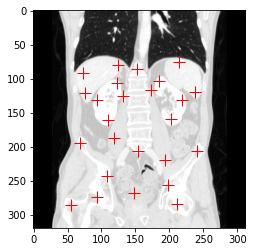

In [8]:
#given: read data from given file
#!wget "https://cloud.imi.uni-luebeck.de/s/maxkR5CAz3KKQLp/download" -O uebung6_data.pth
data = torch.load('../uebung6_data.pth')
img_train = data['img_train']
pts_train = data['pts_train']
img_test = data['img_test']
pts_test = data['pts_test']
ground_truth = data['ground_truth'] 

#convert coordinates from -1 to +1 (only required for plotting)
coordinates_train = (pts_train+1)*torch.Tensor([312-1,320-1]).view(1,1,1,2)/2
coordinates_test = (pts_test+1)*torch.Tensor([312-1,320-1]).view(1,1,1,2)/2

#show one of the images 
i = 5
plt.imshow(torch.clamp(img_train[i,0,:,:],-200,1200),'gray')
plt.plot(coordinates_train[i,:,0,0].numpy(),coordinates_train[i,:,0,1].numpy(),'r+',linewidth=3, markersize=12)
plt.show()

In [9]:
# implement the CNN definition, training procedure, test routine etc.
# Hyperparameter
class Config():
    lr = 0.015
    epochs = 300
    batch_size = 4
    size_heatmap = 17
    size_patch = 23
    n_landmarks = ground_truth.shape[0]
    n_train_images = img_train.shape[0]
    upper_random_bound = 1.2
    lower_random_bound = 0.8

/var/folders/13/90dghwm508z_1q7wqn72n6600000gn/T/ipykernel_18499/63741227.py:37: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)
/var/folders/13/90dghwm508z_1q7wqn72n6600000gn/T/ipykernel_18499/63741227.py:39: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0.0)
/Users/falcolentzsch/.virtualenvs/FVMB/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/var/folders/13/90dghwm508z_1q7wqn72n6600000gn/T/ipykernel_18499/63741227.py:150: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout(pad=3.0)


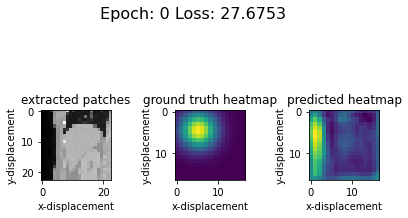

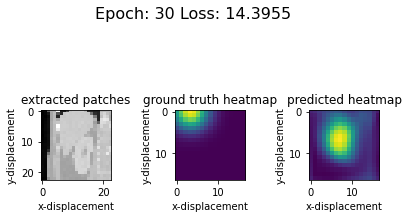

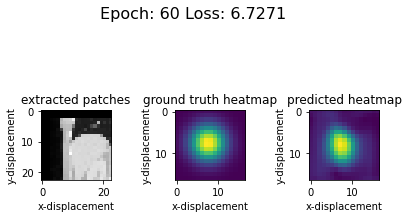

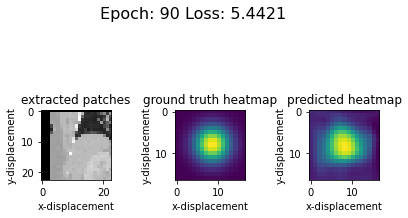

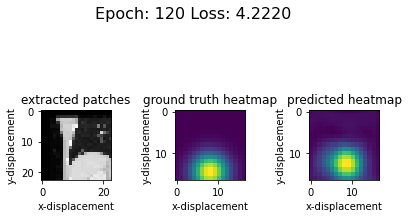

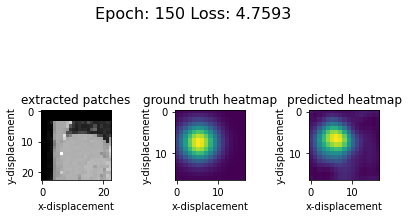

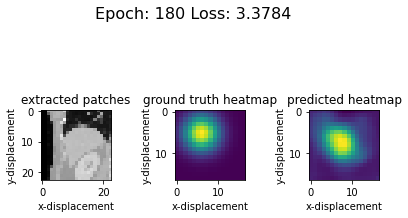

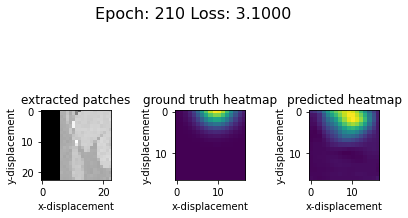

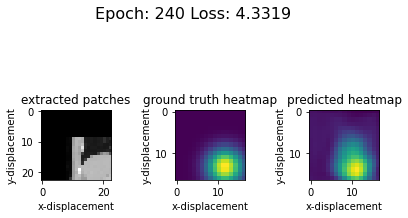

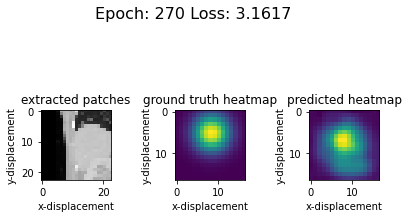

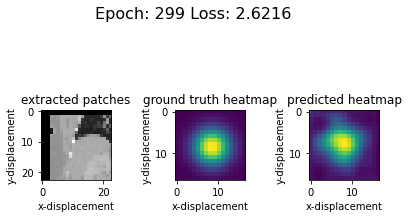

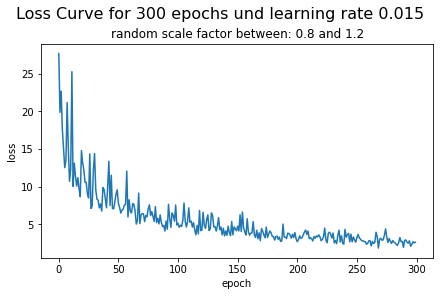

In [10]:
# task 1a heatmaps

'''
Funktion bekommt als Input einen Bash (4) die jeweils 25 Offsets und
generiert daraus die passenden Headmaps.
'''
def create_heatmaps(landmark_offsets):
    # Hier zunächst Grid bauen 17x17 linear absteigend im Bereich von -0,3 bis 0,3.
    displacement_grid_heatmap = F.affine_grid(theta=0.3 * torch.eye(2,3).unsqueeze(0), size=[1,1,Config.size_heatmap,Config.size_heatmap], align_corners=True)
    # Grid hier umshapen zu 1x1x289x2
    displacement_grid_heatmap = displacement_grid_heatmap.view(1,Config.size_heatmap*Config.size_heatmap,2).unsqueeze(0)
    # Gegebene Funktion verwenden um die Headmaps zu erzeugen mit gegeben Offset
    heatmaps = 20 * torch.exp(-40 * (torch.pow(displacement_grid_heatmap[:,:,:,0] - landmark_offsets[:,:,:,0],2) +
                                 (torch.pow(displacement_grid_heatmap[:,:,:,1] - landmark_offsets[:,:,:,1],2))))
    return heatmaps.view(Config.batch_size,Config.n_landmarks,Config.size_heatmap,Config.size_heatmap)

# taks 1b patch extraction
'''
Funktion bekommt als Input die Bilder und die Position der neuen Punkte. Auch wenn hie rauf dem Übungszettel steht das man die original Landmarken übergeben soll.
'''
def create_patches(images, new_landmark_pos, n_patches=Config.batch_size):
    # Hier zunächst Grid bauen 23x23 linear absteigend im Bereich von -0,4 bis 0,4.
    displacement_grid_patches = F.affine_grid(theta=0.4 * torch.eye(2,3).unsqueeze(0), size=[1,1,Config.size_patch,Config.size_patch],align_corners=True)
    # Grid hier umshapen zu 1x1x529x2
    displacement_grid_patches = displacement_grid_patches.view(1,Config.size_patch*Config.size_patch,2).unsqueeze(0)
    # Auf dem Übungszettel stand, dass man die Landmarkenposition und das grid addieren soll
    offset_grid = displacement_grid_patches + new_landmark_pos # hier verschieben
    patches = F.grid_sample(images,offset_grid)
    return patches.view(n_patches,Config.n_landmarks,Config.size_patch,Config.size_patch)




# task 2 CNN
def init_weights(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        nn.init.xavier_normal(m.weight)
        if m.bias is not None:
            nn.init.constant(m.bias, 0.0)

# Bonusaufgabe 1: Netzparameter angepasst
class ConvNet(nn.Module):
    def __init__(self, num_landmarks):
        super(ConvNet, self).__init__()
        self.layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=num_landmarks, out_channels=64, kernel_size=3, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        '''
        self.layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        '''
        self.layer_4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        self.layer_5 = nn.Conv2d(in_channels=64, out_channels=num_landmarks, kernel_size=3, bias=True)

    def forward(self, patches):
        x = self.layer_1(patches)
        x = self.layer_2(x)
        #x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        return x

net = ConvNet(Config.n_landmarks)
net.apply(init_weights)


# task 3: Training the network

# nets initialisieren
net.train()
# optimizer definieren
optimizer = torch.optim.Adam(net.parameters(), lr=Config.lr)
# loss funktion definieren
loss_function = nn.MSELoss()
# liste um loss zu speichern für jede Epoche
loss_train = []

# save some things in pds
pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")


# TRAINING
for epoch in range(Config.epochs):
    idx_epoch = torch.randperm(9)[:8].view(-1, 4)
    for i, idx in enumerate(idx_epoch):
        # 4 Bilder und zugehörige Punkte extrahieren und batch bauen
        batch_images = img_train[idx]
        batch_landmarks_gt = pts_train[idx]
        # batch offset wählen aus dem näheren umfeld, daher hier im die idx aus idx_epoch, die gerade nicht verwendet werden.
        # hier wollen wir für alle 4 Bilder und dort jeweils für alle 25 Punkte einen Offset generieren
        # generieren hier gleich Offsets für alle Bilder nicht nur für 1.

        # Bonusaufgabe 2: Data Augmentation
        lamda = random.uniform(Config.lower_random_bound,Config.upper_random_bound)

        new_landmark_pos = lamda * pts_train[idx_epoch[int((i==0))]] # hier muss vllt noch mehr Zufall rein???
        landmarks_offset = batch_landmarks_gt - new_landmark_pos # Offset

        # generieren der Groundtruth Headmaps für die verschobenen Punkte. Mit der gegeben Formel.
        # Bekommen hier eine headmap mit einem Gauß-Blob an der wahren Position der Landmarke
        heatmaps_gt = create_heatmaps(landmarks_offset)
        #plt.imshow(heatmaps_gt[0,0,:,:].detach().squeeze())
        #plt.show()

        # generieren der patches zu den gegebenen Bilder aus dem batch.
        # Dazu muss die Funktion ebenfalls den Offset bzw. die neue Pixelposition kenn, damit wir um diese herum einen Patch.
        # Hier wird auf dem Übungszettel gesagt man soll um die original Punkte ausschneiden, dann passt die headmap doch aber nicht dazu???
        patches =  create_patches(batch_images, new_landmark_pos)
        #plt.imshow(patches[0,0,:,:].detach().squeeze(), cmap='gray')
        #plt.show()

        optimizer.zero_grad()

        predicted_heatmaps = net(patches)
        loss = loss_function(predicted_heatmaps, heatmaps_gt)
        loss.backward()
        optimizer.step()

    loss_train.append(loss.data.item())


    if (epoch == 0) or (epoch%30 == 0) or (epoch == Config.epochs -1):
        fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=True)
        axs[0].imshow(patches[0,0,:,:].detach().squeeze(), cmap='gray')
        axs[0].set_title('extracted patches')
        axs[0].set_xlabel('x-displacement')
        axs[0].set_ylabel('y-displacement')
        axs[1].imshow(heatmaps_gt[0,0,:,:].detach().squeeze())
        axs[1].set_title('ground truth heatmap')
        axs[1].set_xlabel('x-displacement')
        axs[1].set_ylabel('y-displacement')
        axs[2].imshow(predicted_heatmaps[0, 0,:,:].detach().squeeze())
        axs[2].set_title('predicted heatmap')
        axs[2].set_xlabel('x-displacement')
        axs[2].set_ylabel('y-displacement')
        fig.tight_layout(pad=3.0)
        fig.suptitle('Epoch: {} Loss: {:.4f}'.format(epoch, loss.data.item()), fontsize=16)
        if (epoch == 0) or (epoch == Config.epochs -1) : pdf.savefig(fig)
        plt.show()

fig, axs = plt.subplots(constrained_layout=True)
axs.plot(loss_train)
axs.set_title('random scale factor between: {} and {}'.format(Config.lower_random_bound,Config.upper_random_bound))
axs.set_xlabel('epoch')
axs.set_ylabel('loss')
fig.suptitle('Loss Curve for {} epochs und learning rate {}'.format(Config.epochs, Config.lr), fontsize=16)
pdf.savefig(fig)
plt.show()


In [11]:
# Falls ein altes Netzt noch einmal anders Evaluiert werden muss.
#net = torch.load('net_best.pt')

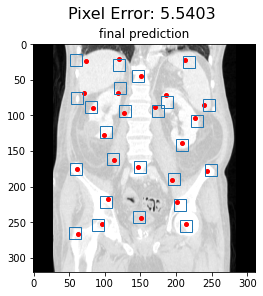

In [12]:
# TESTING
# haben unser Testbild 9 x repliziert
reshape_img_test = img_test.repeat(Config.n_train_images,1,1,1)
# jetzt extrahieren wir aus allen test Bilder die patches zu den Landmarken der train Bilder
# shape: 9x25x23x23
patches_img_test = create_patches(images=reshape_img_test,new_landmark_pos=pts_train , n_patches=9)

# jetzt schicken wir die patches die um die Landmarken Positionen der Trainingsbilder extrahiert wurden durch das Netzt
# und bekommen dann heatmaps, wo die Landmarken in dem TestBild (9x) eigtl liegen müssen
# shape: 9x25x17x17
net.eval()
with torch.no_grad():
    predicted_heatmaps = net(patches_img_test)

displacement_grid_eval = F.affine_grid(theta=0.3 * torch.eye(2,3).unsqueeze(0), size=[1,1,Config.size_heatmap,Config.size_heatmap], align_corners=True)
displacement_grid_eval = displacement_grid_eval.view(1,Config.size_heatmap*Config.size_heatmap,2).unsqueeze(0) + pts_train
predicted_xy = eval(predicted_heatmaps=predicted_heatmaps,xy_sample_target=displacement_grid_eval)




#  results
pix_error = torch.sqrt(torch.sum((coordinates_test[0,:,0,:]-predicted_xy[ground_truth,:])**2,1))
fig, axs = plt.subplots(constrained_layout=True)
axs.imshow(torch.clamp(img_test[0,:,:,:],-200,1200).squeeze(),'gray')
axs.plot(coordinates_test[0,:,0,0].numpy(),coordinates_test[0,:,0,1].numpy(),'r.',linewidth=1.5, markersize=8)
axs.plot(predicted_xy[:,0].numpy(),predicted_xy[:,1].numpy(),'s',linewidth=4, markersize=12, markerfacecolor='none')
axs.set_title('final prediction')
fig.suptitle('Pixel Error: {:.4f} '.format(pix_error.mean().detach().item()), fontsize=16)
pdf.savefig(fig)
#pdf.close()
plt.show()

/Users/falcolentzsch/.virtualenvs/FVMB/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


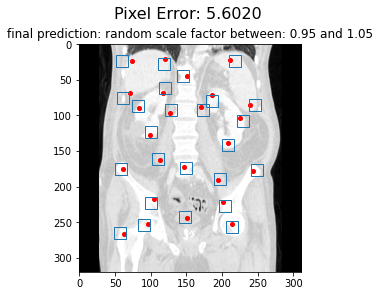

In [13]:
# Bonusaufgabe 3: Testverfahren wie beschrieben anpassen.
# haben unser Testbild (10*9) x repliziert
reshape_img_test = img_test.repeat(10*Config.n_train_images,1,1,1)
lamda_test = random.uniform(0.95,1.05)
random_landmark_position = lamda_test * pts_train.repeat(10,1,1,1)
# jetzt extrahieren wir aus allen test Bilder die patches zu den Landmarken der train Bilder
# shape: 9x25x23x23
patches_img_test = create_patches(images=reshape_img_test,new_landmark_pos=random_landmark_position , n_patches=90)

# jetzt schicken wir die patches die um die Landmarken Positionen der Trainingsbilder extrahiert wurden durch das Netzt
# und bekommen dann heatmaps, wo die Landmarken in dem TestBild (9x) eigtl liegen müssen
# shape: 9x25x17x17
net.eval()
with torch.no_grad():
    predicted_heatmaps = net(patches_img_test)

displacement_grid_eval = F.affine_grid(theta=0.3 * torch.eye(2,3).unsqueeze(0), size=[1,1,Config.size_heatmap,Config.size_heatmap], align_corners=True)
displacement_grid_eval = displacement_grid_eval.view(1,Config.size_heatmap*Config.size_heatmap,2).unsqueeze(0) + random_landmark_position
predicted_xy = eval(predicted_heatmaps=predicted_heatmaps,xy_sample_target=displacement_grid_eval)


#  results
pix_error = torch.sqrt(torch.sum((coordinates_test[0,:,0,:]-predicted_xy[ground_truth,:])**2,1))
fig, axs = plt.subplots(constrained_layout=True)
axs.imshow(torch.clamp(img_test[0,:,:,:],-200,1200).squeeze(),'gray')
axs.plot(coordinates_test[0,:,0,0].numpy(),coordinates_test[0,:,0,1].numpy(),'r.',linewidth=1.5, markersize=8)
axs.plot(predicted_xy[:,0].numpy(),predicted_xy[:,1].numpy(),'s',linewidth=4, markersize=12, markerfacecolor='none')
axs.set_title('final prediction: random scale factor between: {} and {}'.format(0.95,1.05))
fig.suptitle('Pixel Error: {:.4f} '.format(pix_error.mean().detach().item()), fontsize=16)
pdf.savefig(fig)
pdf.close()
plt.show()

In [14]:
# Fals ein Netzt gespeichert werden soll.
#torch.save(net, 'net.pt')